## Credit Card Fraud - Final Flatiron Project (Alexander Benn)

Utilising machine learning to discover credit card fraud from a Kaggle dataset (https://www.kaggle.com/mlg-ulb/creditcardfraud)

The intention of this project is to demonstrate the use of classifier machine learning models in the finance and legal sectors. I have attempted to build a model which will predict credit card fraud with reliable accuracy, in order to target suspicious activities for investigation. To this end I have made a random forest model which will make the necessary decisions to categorise a spending event as either fraud, or not-fraud. This will both save people and banks money, as well as finding out individuals who are committing, or being coerced into, this offence. 

The anonymous nature of this dataset makes it hard to generate concrete solutions for this specific project, but I have successfully identified several sigificant variables. If I were to acquire uncensored data, could be targets for future specific analysis. 

In [3]:
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
import numpy as np
import pandas as pd
import itertools
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from yellowbrick.model_selection import feature_importances
from sklearn import tree
from sklearn.tree import export_graphviz
import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Libraries imported

## Step One - Exploratory Data Analysis, Cleaning and Class Imbalance

The initial step for any data science project is the importing and initial analysis of the data. This includes checking for missing values, exploring the type of data and so on

In [4]:
df = pd.read_csv('creditcard.csv')
df.isnull().values.any()

False

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64


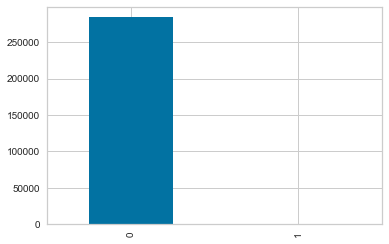

In [3]:
l = df[('Class')]
print(l.value_counts())
df['Class'].value_counts().plot.bar()
plt.show()

In [4]:
print('Raw counts: \n')
print(df['Class'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(df['Class'].value_counts(normalize=True))

Raw counts: 

0    284315
1       492
Name: Class, dtype: int64
-----------------------------------
Normalized counts: 

0    0.998273
1    0.001727
Name: Class, dtype: float64


As we can see here, there is a major class imbalance between 0, representing no fraud, and 1, representing fraud. This is reflective of the real-world situation where fraud is much less common than crime dramas would have us believe! This issue will be addressed later in the notebook with a solution just prior to modelling.

In [5]:
print(df.columns)
df.dtypes
# This is to show the types of data we are working with, so that we are sure there will be no computing errors

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

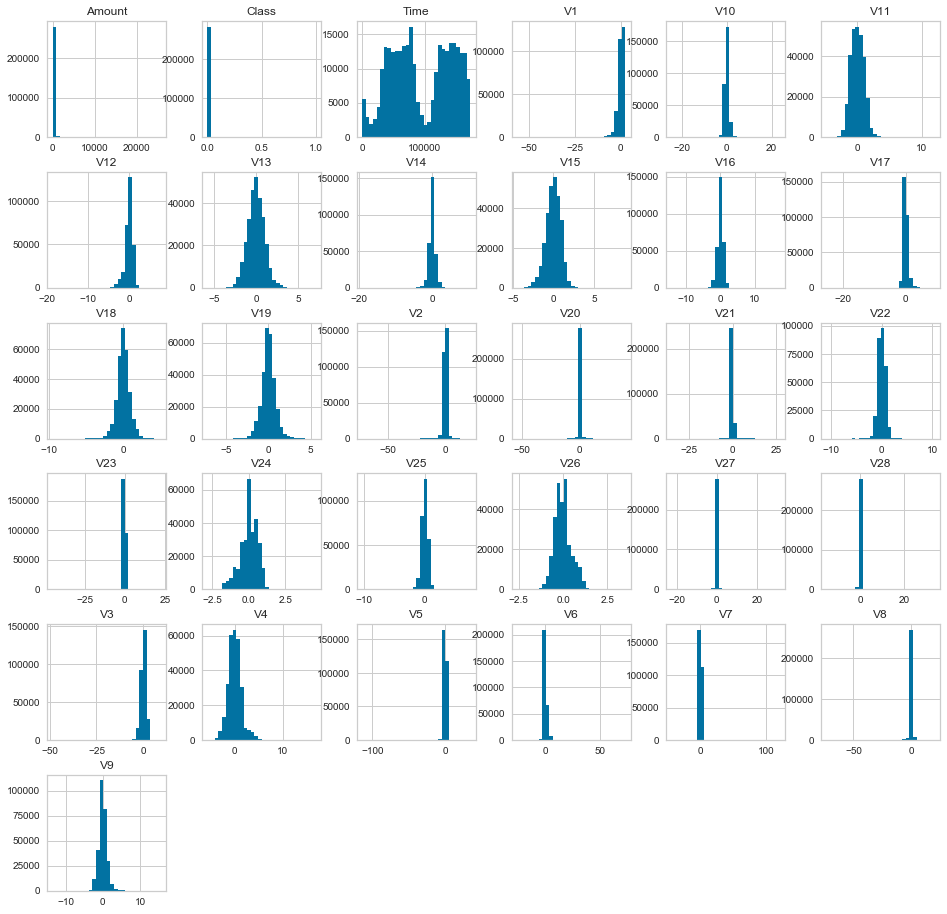

In [6]:
df.hist(bins=30, figsize=(16,16))
plt.show()
# A grid visualisation to show the distributions of each feature in the dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1454fc990>]],
      dtype=object)

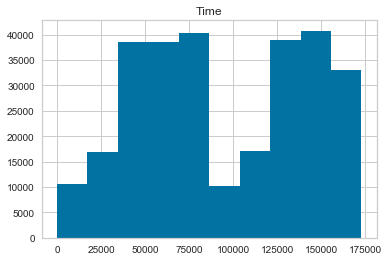

In [7]:
df.hist(column='Time')

As we can see from the above visualisation, there is a noticible 'dip' overnight on the dataset. This reflects the speniding habits of most people, and so we can be reasonably sure that the dataset we have been provided is an accurate reflection of reality, rather than a purely academic exercise

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x144ad7ed0>]],
      dtype=object)

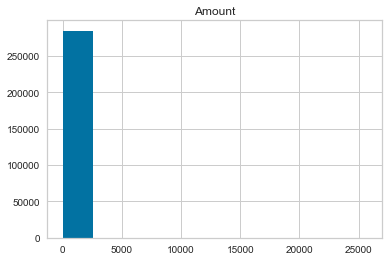

In [8]:
df.hist(column='Amount')

This histogram is to demonstrate the economic volumes we are dealing with. As is clear, there is not a vast quantity of money at stake here, thereby demonstrating that we are dealing with petty, small scale fraud, as opposed to international money laundering or somesuch.

Next we are going to examine the correlations between the variables and the 'target' value, which in this case is the confirmed presence of fraud. We will do this via a 'correlation matrix', which is a way of demonstrating to what extent the features can be excluded based on a suspciously 'too high' correlation. 

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


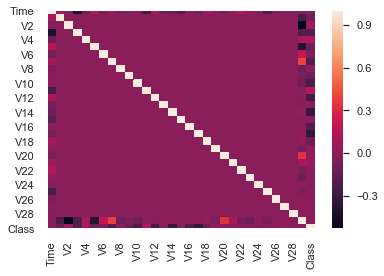

In [9]:
sns.set(style="white")
target = 'Class'
corr_matrix = df.corr()
print(corr_matrix[target].sort_values(ascending=False))
ax = sns.heatmap(corr_matrix)

As we can see from the map and the list of values, there is no significant correlation between the target and the features, to the extent that any of the values need be excluded. However, from other analyses I have done on other training models prior to my final work, there is pne feature (V14) which comes out as 8x more significant that others. The code for this can be found on my GitHub, but I have excluded it from this final modelling process

In [10]:
y = df['Class']
x = df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']]
# Removed v14 due to over significance of features
# Splitting the dataset into target (y) and list of features to be examined (x)

The data is now to be scaled, split into 'x and y train' and 'test' and then the class imbalance is to be addressed

In [11]:
scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x))
# The data must be scaled so that it can be normalised, and also to speed up processing

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state=42)
print(pd.Series(y_train).value_counts())

0    227451
1       394
Name: Class, dtype: int64


In [13]:
x_train_initial, x_test, y_train_initial, y_test = train_test_split(x_scaled, 
                                                                    y, 
                                                                    test_size=0.2, 
                                                                    random_state=42)
print(pd.Series(y_train_initial).value_counts())

0    227451
1       394
Name: Class, dtype: int64


In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train_initial, 
                                                  y_train_initial, 
                                                  test_size=0.2,
                                                  random_state=42)
skf = StratifiedKFold(n_splits=5,random_state=42)
# The data is put through KFold cross validation, so that it becomes less biased, and less 'optimistic' for the final model

Due to our severe class imbalance, of 99% to 1%, we must address this issue. I am utilising SMOTE to do so. SMOTE generates new data points in line with the minority class, so that it equals the majority. This allows for the model to be trained on a sufficiently large dataset, and means it is more likely to able to uncover new points when fresh data is fed into it

In [15]:
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_sample(x_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original class distribution: 

0    284315
1       492
Name: Class, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    181946
0    181946
Name: Class, dtype: int64


## Step Two - Modelling a Random Forest

In my other workbooks, which can be viewed in my GitHub account, I tried two other models, namely a bagged forest and K Nearest Neighbours. I also did significant hyperparameter tuning to make the diagnostic probability for my training data as high as I could. However, the issue was is that is became TOO accurate, with a value of 99.9%, and was therefore significantly overfit. I therefore went with a random forest, which is both a common and well known classifier model, as well as coming in at 94% accuracy, which reflects a more realistically fit model. I did not tune this model, as when I tried to do so even with only minor tweaks, I ended up with scores in excess of 99% again. 

In [16]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(x_train_resampled, y_train_resampled)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
forest.score(x_train_resampled, y_train_resampled)

0.9399492157013619

## Final Model Visualisations - ROC Curve and Feature Importance

I utilised this model to generate a ROC curve, which demonstrated the diagnostic capabilities of my model. The probability value demonstrates how likely my model is to discover the most important features from the training dataset. Given the value of 94%, we can have confidence in this model

In [18]:
skf = StratifiedKFold(n_splits=5,random_state=42)
y_prob = cross_val_predict(forest ,x_train_resampled,y_train_resampled,method='predict_proba', cv=skf)[:,1]


In [19]:
fpr,tpr,threshold = roc_curve(y_train_resampled, y_prob)

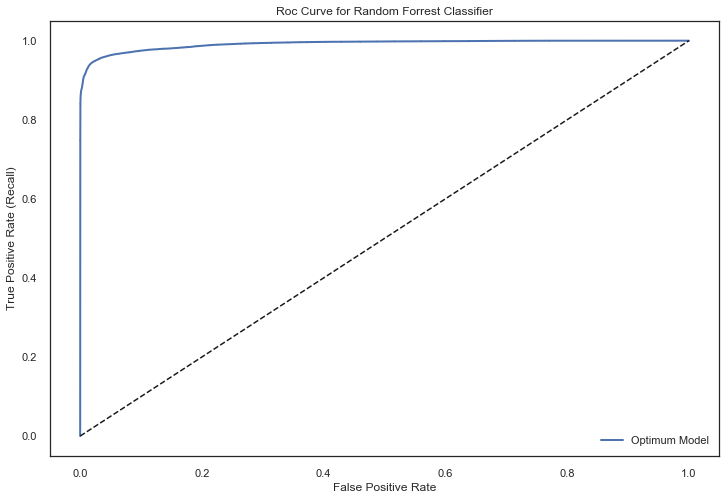

In [20]:
def plot_roc_curve(fpr, tpr, label=None):
    fig = plt.figure(figsize=(12,8))
    plt.plot(fpr,tpr,linewidth= 2, label=label)
    plt.plot([0,1], [0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Roc Curve for Random Forrest Classifier')
    plt.legend(loc=4)

plot_roc_curve(fpr, tpr, label='Optimum Model')
plt.show()

The area under the curve demonstrates the accuracy of the model

In [21]:
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

feature_importances = np.mean([
    tree.feature_importances_ for tree in forest
], axis=0)

In [22]:
feature_importance = pd.DataFrame(feature_importances)
feature_importance.rename(columns={0:'Importance'}, inplace=True)
feature_importance['Feature'] =x_train.columns
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance)

    Importance  Feature
10    0.180057       10
16    0.135030       16
12    0.118875       12
4     0.116800        4
15    0.106782       15
11    0.105428       11
3     0.052166        3
7     0.035256        7
2     0.035130        2
9     0.023127        9
5     0.014942        5
18    0.014690       18
17    0.014104       17
20    0.012830       20
6     0.010421        6
8     0.006906        8
19    0.003757       19
1     0.002661        1
28    0.002169       28
25    0.002006       25
26    0.001918       26
27    0.001151       27
13    0.000819       13
23    0.000669       23
14    0.000639       14
22    0.000574       22
0     0.000470        0
24    0.000410       24
21    0.000214       21


In [23]:
top_20_features = feature_importance.head(20)

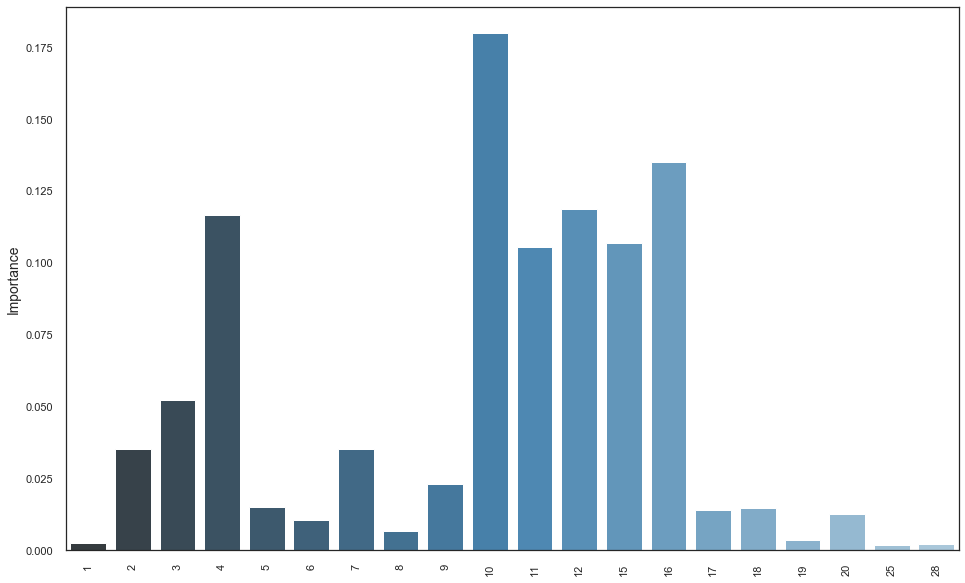

In [24]:
plt.figure(figsize=(16,10))
sns.barplot(x='Feature', y='Importance', data=top_20_features, palette="Blues_d")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel('Importance', fontsize=14)
plt.show()


This graph shows the most significant features for the dataset, with 2, 3, 4, 10, 11, 12, 15 and 16 being of significant interest. As mentioned however, the data is anonymised, and so I am unable to draw specific conclusions from this research. I can say though, that the model is perfoming analysis well, and will give useful outputs on what features most affect the potential for fraud to be committed. 

## Final Model

The test data is only put into the final model once, this is to make sure it is properly fit, and that it is not affected by biases or over optimisation. The goal is to get an accurate reflection on the performance of the model

In [32]:
forest.score(x_test , y_test)

0.9995435553526912

As we can see, we have attained a 99% accurate model. This seems very high, but could be due to the model accurately identifying the vast class imbalance, and noticing the 'non fraud' data point with a very high degree of accuracy. This is still a useful model however, as it will identify the features associated with fraud. 

In [27]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in forest
], axis=0)

In [28]:
feature_importance = pd.DataFrame(feature_importances)
feature_importance.rename(columns={0:'Importance'}, inplace=True)
feature_importance['Feature'] =x_train.columns
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance)

    Importance  Feature
16    0.233772       16
12    0.150475       12
15    0.115716       15
10    0.111696       10
11    0.083262       11
17    0.054293       17
9     0.036876        9
3     0.030090        3
4     0.026241        4
7     0.023888        7
25    0.016781       25
0     0.010803        0
2     0.010389        2
5     0.010260        5
26    0.009773       26
14    0.008952       14
1     0.008264        1
21    0.006747       21
19    0.006645       19
8     0.006306        8
28    0.006215       28
22    0.005857       22
18    0.005120       18
20    0.003877       20
6     0.003825        6
27    0.003808       27
24    0.003578       24
23    0.003462       23
13    0.003028       13


In [29]:
top_20_features = feature_importance.head(20)

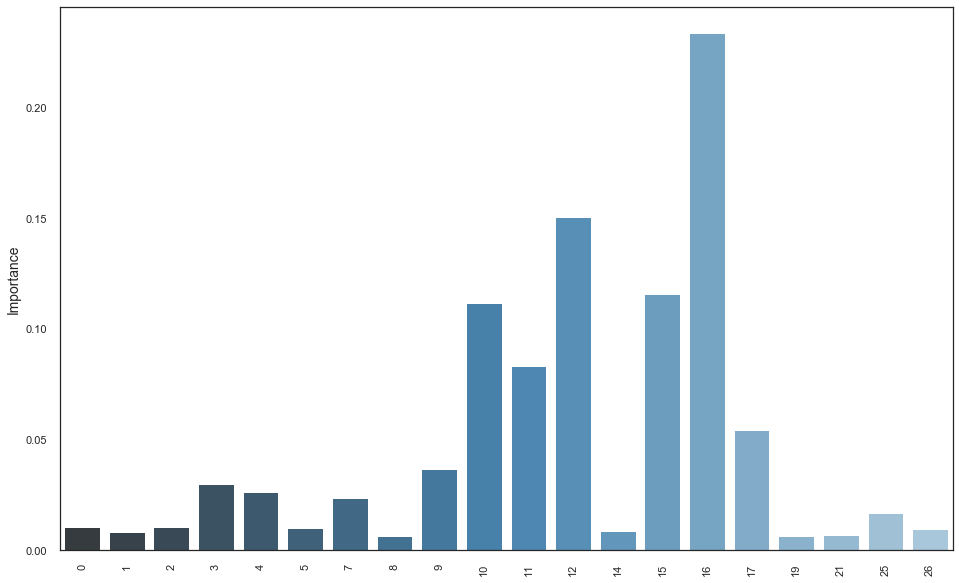

In [30]:
plt.figure(figsize=(16,10))
sns.barplot(x='Feature', y='Importance', data=top_20_features, palette="Blues_d")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel('Importance', fontsize=14)
plt.show()

Interestingly, the final feature importances show us that features 1 - 10 are less significant in identifying fraud, whereas 10 - 17 are much more so. AS I have mentioned, it is impossible to draw conclusions from this data based on the information given as it is anonymous, but in future if I were given access, some interesting conclusions could certainly be drawn.